In [1]:
from __future__ import print_function
from __future__ import division
from collections import defaultdict, OrderedDict, Counter
import calendar
import datetime
import dateutil.parser as dparser
from glob import glob
import hdbscan
import logging
import matplotlib.pyplot as plt
import matplotlib.path as mplpath
from matplotlib_scalebar.scalebar import ScaleBar
import os
import numpy as np
import pandas as pd
import skimage
import skimage.io as skio
from skimage import draw
from sklearn.metrics import pairwise_distances
import subprocess
import sys
import time
import ujson as json

from mpl_toolkits.basemap import Basemap
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

In [2]:
 def load_ais_for_year(year):
    query = """
    SELECT ssvid,
           year,
           month,
           day,
           180 / ACOS(-1) * ATAN2(lonsin, loncos) AS lon,
           lat
           
    FROM (
        SELECT a.ssvid, 
               EXTRACT(YEAR FROM timestamp) year,
               EXTRACT(MONTH FROM timestamp) month,
               EXTRACT(DAY FROM timestamp) day,
               AVG(SIN(ACOS(-1) / 180 * a.lon)) AS lonsin, 
               AVG(COS(ACOS(-1) / 180 * a.lon)) AS loncos, 
               AVG(a.lat) lat 
        FROM 
        `world-fishing-827.pipe_production_b.position_messages_{}*` a
            JOIN
        `world-fishing-827.gfw_research.vessel_info_allyears_20181002` b
           ON a.ssvid = CAST(b.mmsi AS STRING)
        WHERE seg_id in (select seg_id from gfw_research.pipe_production_b_segs where good_seg)
        AND a.distance_from_shore_m > 100000
        AND b.best_label = "drifting_longlines"
        GROUP BY a.ssvid, year, month, day
    )
    ORDER BY ssvid
    """.format(year)
    return pd.read_gbq(query, dialect='standard', project_id='world-fishing-827')


df = load_ais_for_year(2017)
df_by_date = {}
d = datetime.date(2017, 1, 1)
while d < datetime.date(2018, 1, 1):
    datestr = "{:4d}{:02d}{:02d}".format(d.year, d.month, d.day)
    mask = (df.year == d.year) & (df.month == d.month) & (df.day == d.day)
    df_by_date[datestr] = df[mask]
    d += datetime.timedelta(days=1)

//anaconda/envs/ml2/lib/python2.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
# df_by_date = {}

In [4]:
#  def load_ais_for_datestr(datestr):
#     query = """
#     SELECT a.ssvid, 
#            AVG(a.lon) lon, 
#            AVG(a.lat) lat FROM 
#     `world-fishing-827.pipe_production_b.position_messages_*` a
#         JOIN
#     `world-fishing-827.gfw_research.vessel_info_allyears_20181002` b
#        ON a.ssvid = CAST(b.mmsi AS STRING)
#     WHERE seg_id in (select seg_id from gfw_research.pipe_production_b_segs where good_seg)
#     AND a.distance_from_shore_m > 100000
#     AND b.best_label = "drifting_longlines"
#     AND a._TABLE_SUFFIX = '{}'
#     GROUP BY a.ssvid
#     ORDER BY a.ssvid
#     """.format(datestr)
#     return pd.read_gbq(query, dialect='standard')

# d = datetime.date(2017, 1, 1)
# while d < datetime.date(2018, 1, 1):
#     datestr = "{:4d}{:02d}{:02d}".format(d.year, d.month, d.day)
#     print("Querying", datestr)
#     if datestr not in df_by_date:
#         df_by_date[datestr] = load_ais_for_datestr(datestr)
#     d += datetime.timedelta(days=1)

In [5]:
pruned = {}
def prune_china(df):
    rows = []
    for x in df.itertuples():
        if 105 <= x.lon <= 130 and 10 <= x.lat <= 40:
            continue
        rows.append(x)
    return pd.DataFrame(rows)

for datestr in df_by_date:
    pruned[datestr] = prune_china(df_by_date[datestr])

In [6]:
def is_candidate(mmsi):
    if len(mmsi) != 9:
        return False
    if not '2' <= mmsi[0] <= '7':
        return False
    return True

In [7]:
all_ssvid = set()
for v in pruned.values():
    all_ssvid |= set(v.ssvid)
valid_ssvid = sorted({x for x in all_ssvid if is_candidate(x)})


# For each date compute distances between vessels


def create_Cn(date):
    """
    Unlabelled rows are 0 (either because vessel
    no broadcasting on day or not grouped)
    
    Other rows are +1 for cluster and -1 elsewhere
    """
    df = pruned[date]
    n_ssvid = len(valid_ssvid)
    ssvid_map = {ssvid : i for (i, ssvid) in enumerate(df.ssvid)}
    lonlats = df[['lon', 'lat']].values
    C = np.empty([n_ssvid, 2])
    C.fill(np.nan)
    for i, ssvid in enumerate(valid_ssvid):
        if ssvid not in ssvid_map:
            continue
        j = ssvid_map[ssvid]
        C[i, :] = lonlats[j]
    return C

def create_C():
    Cns = []
    for date in sorted(pruned):
        Cns.append(create_Cn(date))
    return np.concatenate(Cns, axis=1)

C = create_C()

# Compute the distances, ignoring infs
AVG_EARTH_RADIUS = 6371  # in km
n = len(C)
distances = np.zeros([n, n])
Cr = np.radians(C)
for i in range(n):
    d2s = []
    for j in range(0, Cr.shape[1], 2):
        lat1 = Cr[i, None, j + 1]
        lat2 = Cr[:, j + 1]
        lng1 = Cr[i, None, j]
        lng2 = Cr[:, j]
        lat = lat2 - lat1
        lng = lng2 - lng1
        d = np.sin(lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng / 2) ** 2
        h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
        d2s.append(h ** 2)
    distances[i] = np.sqrt(np.nanmean(d2s, axis=0))
distances[np.isnan(distances)] = np.inf

/anaconda/envs/ml2/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


In [8]:
# meta_clusterer = hdbscan.HDBSCAN(metric='precomputed', min_samples=3, min_cluster_size=12, alpha=1.5)
distances2 = np.minimum(distances, 200)
distances2[np.isinf(distances)] = np.inf

meta_clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=10)
meta_clusterer.fit(distances)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='precomputed', min_cluster_size=10, min_samples=None, p=None,
    prediction_data=False)

In [15]:
len(indices)

17

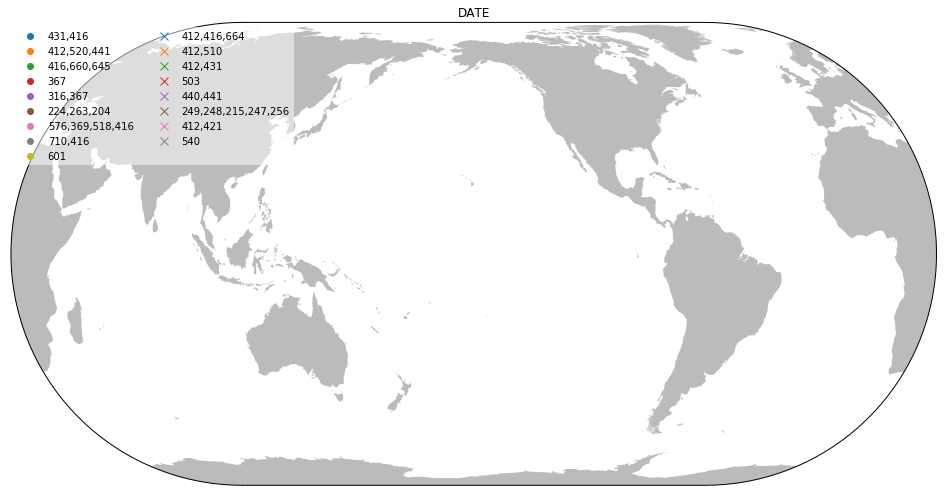

In [18]:
n_fleets = 20
n_fleets = min(n_fleets, max(meta_clusterer.labels_) + 1)

fleet_map_2 = defaultdict(list)
for ssvid, lbl in zip(valid_ssvid, meta_clusterer.labels_):
    if lbl != -1:
        fleet_map_2[lbl].append(ssvid)

fleet_ids = fleet_map_2.keys()
fleet_lengths = [len(fleet_map_2[x]) for x in fleet_ids]
indices = np.argsort(fleet_lengths)[::-1]

fig, ax = plt.subplots(figsize = (14, 7))

projection = Basemap(lon_0=-155, projection='eck4', resolution="l", ax=ax)
projection.fillcontinents(color='#BBBBBB',lake_color='#BBBBBB')

points, = plt.plot([], [], '.', alpha=1, markersize=4, color='#dddddd')
point_sets = [points]
cmap = plt.get_cmap("tab10")
CYCLE = 9
for i in range(n_fleets):
    color = cmap(i % CYCLE)
    marker = ['.', 'x', '+'][i // CYCLE]
    markersize = [12, 8, 8][i // CYCLE]
    fid = fleet_ids[indices[i]]
    cnts = Counter([x[:3] for x in fleet_map_2[fid]]).most_common()
    sigssvid = [s for (s, c) in cnts if c / len(fleet_map_2[fid]) > 0.1]
    label = ",".join(sigssvid)
    points, = plt.plot([], [], marker, alpha=1, color=color, markersize=markersize, label=label)
    point_sets.append(points)


title = plt.title('DATE')
legend = plt.legend(loc='upper left', framealpha=0.5, ncol=2)
for lh in legend.legendHandles: 
    lh._legmarker.set_alpha(1)
legend.get_frame().set_linewidth(0.0)

plt.tight_layout()

def init():
    for i in range(n_fleets + 1):
        point_sets[i].set_data([], [])
        return point_sets

def animate(i):
    datestr = sorted(pruned)[i]
    df = pruned[datestr]
    lons, lats = projection(df.lon.values, df.lat.values)
    mask = [y in valid_ssvid for y in df.ssvid]
    point_sets[0].set_data(lons[mask], lats[mask])
    for j, n in enumerate(indices[:n_fleets]):
        fid = fleet_ids[n]
        ssvids = fleet_map_2[fid]
        mask = [y in ssvids for y in df.ssvid]
        lons, lats = projection(df.lon[mask].values, df.lat[mask].values)
        point_sets[j+1].set_data(lons, lats)
    title.set_text(datestr)
    return point_sets


# Compile the animation. Setting blit=True will only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(pruned), interval=500, 
                               blit=True)

In [19]:
# HTML(anim.to_html5_video())

In [20]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

anim.save('fleet_demo.mp4', writer=writer)

# OLD STUFF

In [11]:
## from collections import Counter
cnt = Counter([x[:3] for x in fleet_map_2[1]])
cnt.most_common(1000)
# 431 -- Japan
# 416 -- Taiwan
# 412,413 -- China
# 316/367 -- Canada/US
# 224,225/263 : Spain / Portugal
# 440,441 : Korea


[(u'412', 12), (u'421', 2), (u'413', 1)]

In [12]:
n_fleets = 6

fleet_map_temp = defaultdict(list)
for ssvid, v in fleet_map.items():
    v.sort()
    metric, fleet_id = v[-1]
    fleet_map_temp[fleet_id].append(ssvid)
fleet_ids = fleet_map_temp.keys()
fleet_lengths = [len(fleet_map_temp[x]) for x in fleet_ids]
indices = np.argsort(fleet_lengths)[::-1]
valid_fleet_ids = set([fleet_ids[x] for x in indices[:n_fleets]])

fleet_map_2 = defaultdict(list)
for ssvid, v in fleet_map.items():
    v = [(m, fid) for (m, fid) in v if fid in valid_fleet_ids]
    if v:
        v.sort()
        metric, fleet_id = v[-1]
        fleet_map_2[fleet_id].append(ssvid)


fleet_ids = fleet_map_2.keys()
fleet_lengths = [len(fleet_map_2[x]) for x in fleet_ids]
indices = np.argsort(fleet_lengths)[::-1]

fig, ax = plt.subplots(figsize = (14, 7))

projection = Basemap(lon_0=-155, projection='eck4', resolution="l", ax=ax)
projection.fillcontinents(color='#AAAAAA',lake_color='#AAAAAA')

points, = plt.plot([], [], '.', alpha=0.3, markersize=14, color='#dddddd')
point_sets = [points]
for i in range(n_fleets):
    fid = fleet_ids[indices[i]]
    points, = plt.plot([], [], '.', alpha=0.3, markersize=14, label="Fleet {}".format(fid))
    point_sets.append(points)


title = plt.title('DATE')
legend = plt.legend(loc=2)
for lh in legend.legendHandles: 
    lh._legmarker.set_alpha(1)

def init():
    for i in range(n_fleets + 1):
        point_sets[i].set_data([], [])
        return point_sets

def animate(i):
    datestr = sorted(pruned)[i]
    df = pruned[datestr]
    lons, lats = projection(df.lon.values, df.lat.values)
    mask = [y in valid_ssvid for y in df.ssvid]
    point_sets[0].set_data(lons[mask], lats[mask])
    for j, n in enumerate(indices[:n_fleets]):
        fid = fleet_ids[n]
        ssvids = fleet_map_2[fid]
        mask = [y in ssvids for y in df.ssvid]
        lons, lats = projection(df.lon[mask].values, df.lat[mask].values)
        point_sets[j+1].set_data(lons, lats)
    title.set_text(datestr)
    return point_sets


# Compile the animation. Setting blit=True will only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(pruned), interval=300, 
                               blit=True)

HTML(anim.to_html5_video())

NameError: name 'fleet_map' is not defined

In [ ]:
clusterer_by_date2 = {}
cluster_data_by_date2 = {}
dates = sorted(pruned)
for i, datestr in enumerate(dates[:-2]):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
    df0 = pruned[datestr]
    df1 = pruned[dates[i+1]] 
    df2 = pruned[dates[i+2]] 
    # TODO: only look at ssvid in both df0 and df1
    # TODO: features are lat0, lon0, lat1, lon1
    #  Sorted by ssvid, so use mask.
    ssvid = set(df0.ssvid) & set(df1.ssvid) & set(df2.ssvid)
    mask0 = [(x in ssvid) for x in df0.ssvid]
    mask1 = [(x in ssvid) for x in df1.ssvid]
    mask2 = [(x in ssvid) for x in df2.ssvid]
    df0 = df0[mask0]
    df1 = df1[mask1]
    df2 = df2[mask2]
    assert all(df0.ssvid.values == df1.ssvid.values)
    assert all(df0.ssvid.values == df2.ssvid.values)
    lon0, lat0 = df0[['lon', 'lat']].values.transpose()
    lon1, lat1 = df1[['lon', 'lat']].values.transpose()
    lon2, lat2 = df2[['lon', 'lat']].values.transpose()
    clusterer.fit(np.transpose([lon0, lat0, lon1, lat1, lon2, lat2]))
    print(datestr, len(set(clusterer.labels_)))
    clusterer_by_date2[datestr] = clusterer
    cluster_data_by_date2[datestr] = np.transpose([df0.ssvid.values, lon0, lat0])

In [ ]:
datestr = '20170908'
df = pruned[datestr]
clusterer = clusterer_by_date[datestr]
cvalues = cluster_data_by_date[datestr]

labels = sorted(set(clusterer.labels_))
if labels[0] == -1:
    labels = labels[1:]
    
counts = []
for x in labels:
    counts.append(sum([(y == x) for y in clusterer.labels_]))

index_order = np.argsort(counts)[::-1]


plt.figure(figsize=(16, 8))
for i, n in enumerate(index_order[:10]):
    l = labels[n]
    mask = [(y == l) for y in clusterer.labels_]
    lon = cvalues[mask, 1]
    lat = cvalues[mask, 2]
    plt.plot(lon, lat, '.', alpha=0.2, label="group {}".format(i + 1))
plt.show()

datestr = '20170918'
df = pruned[datestr]
clusterer = clusterer_by_date[datestr]
cvalues = cluster_data_by_date[datestr]

labels = sorted(set(clusterer.labels_))
if labels[0] == -1:
    labels = labels[1:]
    
counts = []
for x in labels:
    counts.append(sum([(y == x) for y in clusterer.labels_]))

index_order = np.argsort(counts)[::-1]


plt.figure(figsize=(16, 8))
for i, n in enumerate(index_order[:10]):
    l = labels[n]
    mask = [(y == l) for y in clusterer.labels_]
    lon = cvalues[mask, 1]
    lat = cvalues[mask, 2]
    plt.plot(lon, lat, '.', alpha=0.2, label="group {}".format(i + 1))
plt.show()

datestr = '20170928'
df = pruned[datestr]
clusterer = clusterer_by_date[datestr]
cvalues = cluster_data_by_date[datestr]

labels = sorted(set(clusterer.labels_))
if labels[0] == -1:
    labels = labels[1:]
    
counts = []
for x in labels:
    counts.append(sum([(y == x) for y in clusterer.labels_]))

index_order = np.argsort(counts)[::-1]


plt.figure(figsize=(16, 8))
for i, n in enumerate(index_order[:10]):
    l = labels[n]
    mask = [(y == l) for y in clusterer.labels_]
    lon = cvalues[mask, 1]
    lat = cvalues[mask, 2]
    plt.plot(lon, lat, '.', alpha=0.2, label="group {}".format(i + 1))
plt.show()

In [ ]:
all_ssvid = set()
for v in pruned.values():
    all_ssvid |= set(v.ssvid)

valid_ssvid = {x for x in all_ssvid if is_candidate(x)}
candidates = valid_ssvid.copy()

T1 = 0.5
T2 = 0.67

fleet_map = defaultdict(list)
fleet_id = 0
while candidates:
    fleet_id += 1 # Start with 1
    # Pick a random ssvid from candidates
    examplar = np.random.choice(sorted(candidates))
    # Find all vessels that overlap with the examplar at least T.
    print(len(candidates))
    totals = defaultdict(int)
    overlaps = defaultdict(int)
    for date in sorted(pruned)[:-1]:
        clusterer = clusterer_by_date[date]
        cdata = cluster_data_by_date[date]
        mask1 = (cdata[:, 0] == examplar)
        if not mask1.sum():
            continue
        [label] = clusterer.labels_[mask1]
        if label == -1:
            continue
        presence = (clusterer.labels_ != -1)
        grouped = (clusterer.labels_ == label)
        for ssvid, is_present, is_grouped in zip(cdata[:, 0], presence, grouped):
            totals[ssvid] += is_present
            overlaps[ssvid] += is_grouped
    for ssvid in valid_ssvid:
        if not totals[ssvid]:
            continue
        metric = overlaps[ssvid] / totals[ssvid]
        if metric >= T1:
            fleet_map[ssvid].append((metric, fleet_id))
        if metric >= T2 and ssvid in candidates:
            candidates.remove(ssvid)
    # Always remove example
    if examplar in candidates:
        print("Warning, examplar", examplar, "didn't meet threshold")
        candidates.remove(examplar)

In [ ]:
clusterer_by_date = {}
cluster_data_by_date = {}
dates = sorted(pruned)
for i, datestr in enumerate(dates[:-1]):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
    df0 = pruned[datestr]
    df1 = pruned[dates[i+1]] 
    # TODO: only look at ssvid in both df0 and df1
    # TODO: features are lat0, lon0, lat1, lon1
    #  Sorted by ssvid, so use mask.
    ssvid = set(df0.ssvid) & set(df1.ssvid)
    mask0 = [(x in ssvid) for x in df0.ssvid]
    mask1 = [(x in ssvid) for x in df1.ssvid]
    df0 = df0[mask0]
    df1 = df1[mask1]
    assert all(df0.ssvid.values == df1.ssvid.values)
#     next_df = pruned[dates[i+1]] 
#     is_us = np.array([x[:3] in ['338', '366', '367', '368', '369'] for x in df.ssvid])
#     is_china = np.array([x[:3] in ['412', '413'] for x in df.ssvid])
    lon0, lat0 = df0[['lon', 'lat']].values.transpose()
    lon1, lat1 = df1[['lon', 'lat']].values.transpose()
    clusterer.fit(np.transpose([lon0, lat0, lon1, lat1]))
    print(datestr, len(set(clusterer.labels_)))
    clusterer_by_date[datestr] = clusterer
    cluster_data_by_date[datestr] = np.transpose([df0.ssvid.values, lon0, lat0])